# Overview

This Jupyter notebook predicts large-area tiles downloaded in `4a-download-large-area` with a trained model from `3-model-master`. The notebook is broken down into the following sections:

   * **Model loading**:
   * **Coordinate identification**
   * **Tiling**
   * **Loading and predicting**
   * **Mosaicing**
   * **Writing TIF**
   * **Writing COG**

In [2]:
!pip freeze

absl-py==0.7.1
affine==2.3.0
ago==0.0.93
anaconda-client==1.7.2
anaconda-navigator==1.9.7
appnope==0.1.0
arrow==0.14.2
asn1crypto==0.24.0
astor==0.8.0
astropy==4.0.1.post1
attrs==19.3.0
Automat==0.7.0
awscli==1.16.227
backcall==0.1.0
beautifulsoup4==4.7.1
binaryornot==0.4.4
bleach==3.1.0
blis==0.2.4
bokeh==2.1.1
boto3==1.9.166
botocore==1.12.217
bs4==0.0.1
cachetools==4.1.0
cchardet==2.1.6
certifi==2019.6.16
cffi==1.12.3
chardet==3.0.4
Click==7.0
click-plugins==1.1.1
cligj==0.5.0
clyent==1.2.2
colorama==0.3.9
conda==4.7.5
conda-build==3.17.8
conda-package-handling==1.3.10
conda-verify==3.1.1
confuse==1.1.0
constantly==15.1.0
cookiecutter==1.6.0
cryptography==2.7
cssselect==1.1.0
cycler==0.10.0
cymem==2.0.2
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distro==1.5.0
docutils==0.15.2
dotmap==1.3.8
editdistance==0.5.3
elasticsearch==7.0.4
en-core-web-sm==2.1.0
entrypoints==0.3
fastprogress==0.2.3
feedfinder2==0.0.4
feedparser==5.2.1
filelock==3.0.12
Fiona==1.8.13.post1
F

In [4]:
!curl https://restoration-monitoring-external.s3.amazonaws.com/restoration-mapper/example/example-raw.zip \
    -o ../data/data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  374M  100  374M    0     0  11.4M      0  0:00:32  0:00:32 --:--:-- 13.0M 0     0  13.0M      0  0:00:28  0:00:06  0:00:22 13.3M 0  0:00:27  0:00:10  0:00:17 14.0M   0     0  11.2M      0  0:00:33  0:00:28  0:00:05 5573k


# 1.0 Package imports

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../src/downloading/utils.py
%run ../src/models/utils.py

Using TensorFlow backend.


# Parameter definitions

In [52]:
LANDSCAPE = 'brazil-buffer'
INPUT = "../tile_data/{}/2019/processed/".format(LANDSCAPE)
OUTPUT = "../tile_data/{}/2019/output/".format(LANDSCAPE)

y_size = max([int(x) for x in os.listdir(INPUT) if any(i.isdigit() for i in x)])

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

# 2.0 Model loading

In [ ]:
import urllib.request
import zipfile

if not os.path.exists("../models/"):
    os.makedirs("../models/")
    
    print("Downloading model file from cloud storage")
    urllib.request.urlretrieve("https://storage.googleapis.com/rm-models/master.zip", "master.zip")
    with zipfile.ZipFile("master.zip", 'r') as zip_ref:
        zip_ref.extractall("../models/")

In [4]:
path = "../models/master/"
#path = "../models/april-27-ft/master/" # master
#path = '../models/lac-3/142-85-5/'
#path = '../models/malawi/138-85-9/'
#path = '../models/cameroonniger/140-77-2/' # niger
#path = '../models/cameroonniger/127-81-8/' # cameroon
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/lac-3/142-85-5/model


In [5]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

## 2.2 Tiling functions

100 81 90 90 361
(140, 140)


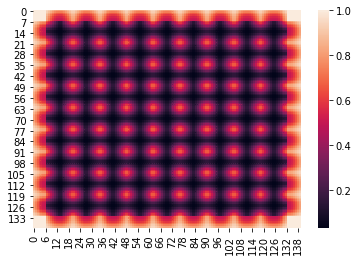

In [44]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3.5)
arr = arr[:7, :7]

SIZE = 10
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)

arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)
print(upright.shape)

# 2.3 Prediction functions

In [45]:
min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    pred_files = [INPUT + str(y_col) + "/" + str(folder) + ".hkl"]
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    for i in range(len(pred_files)):
        x = hkl.load(pred_files[0])
        if np.max(x) > 100:
            x = convert_to_float(x)
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (71, 2, 71, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (142, 142), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[..., x] = np.clip(pred_x[..., x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[..., x] - midrange) / (rng / 2)
        pred_x[..., x] = standardized

    preds = []
    batches = [x for x in range(0, 341, 20)] + [361]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3,
                                                 length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0) * normal

    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

# 2.4 Run predictions

In [46]:
all_preds = []
for row in tnrange(0, 5):
    for column in range(0, 5):
        output_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        input_file = f"{INPUT}{str(row)}/{str(column)}.hkl"
        
        if os.path.exists(input_file) and not os.path.exists(output_file):
            prediction = load_and_predict_folder(row, column)
            if not os.path.exists(OUTPUT + str(row) + "/"):
                os.makedirs(OUTPUT + str(row) + "/")
            prediction = prediction[7:-7, 7:-7]
            np.save(output_file, prediction)

# 2.5 Mosaic predictions

In [47]:
max_x = 5
max_y = 5

start_x = 0
start_y = 0

predictions = np.full(
    (
    (max_y-start_y)*126,
    (max_x-start_x)*126
    ), -1, dtype = np.float64 )

max_y_out = predictions.shape[0]
max_x_out = predictions.shape[1]

numb = 0
for row in range(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            predictions[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = prediction
            
print(f"There are {numb*4000} hectares processed")

There are 4000 hectares processed


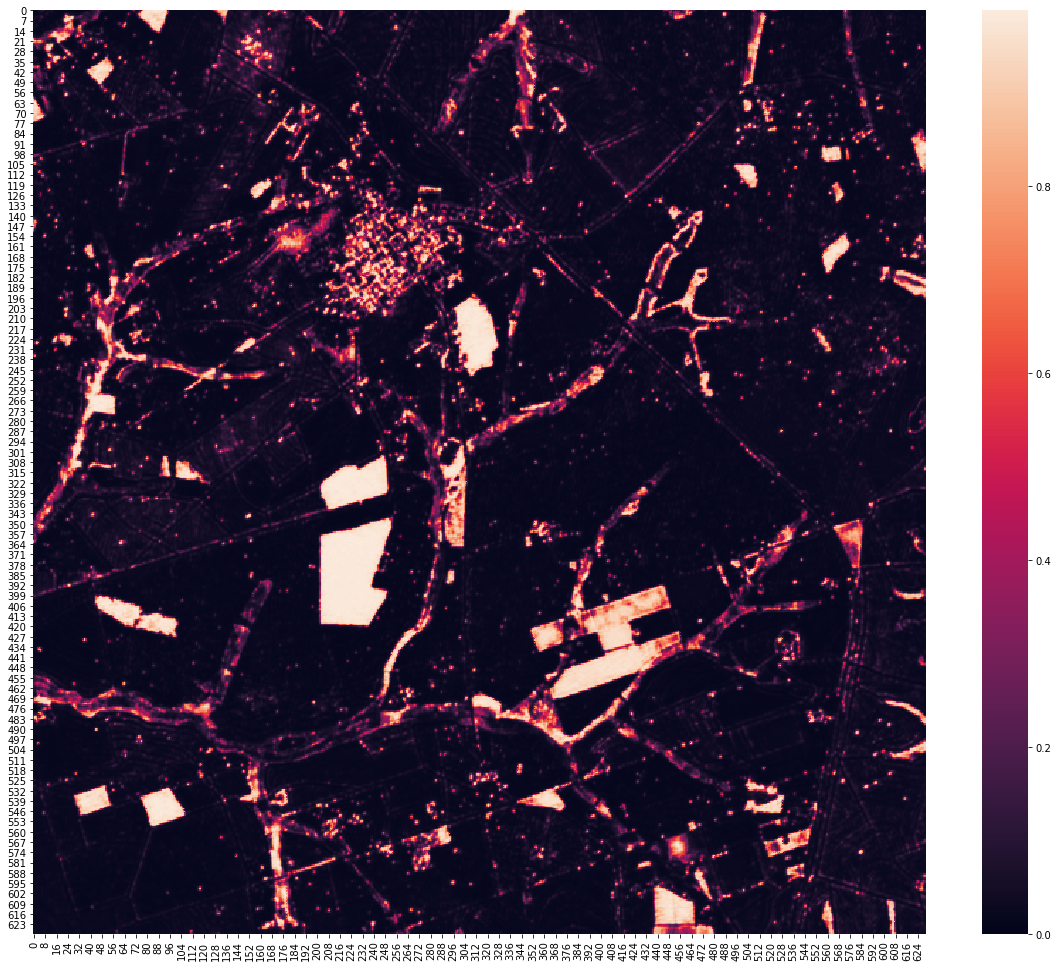

In [48]:
x_shape = predictions.shape[1] / predictions.shape[0] * 17
plt.figure(figsize=(20, 17))
sns.heatmap(predictions, vmin = 0)

# 2.6 Sharpen predictions

In [38]:
def recover_new(arr, thresh):
    adding = 0
    stacked = np.copy(arr)
    for window_x in tnrange(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            #
            five_w = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            three_w = stacked[window_x-1:window_x+2, window_y-1:window_y+2]
            
            n_five_above = len(five_w[np.argwhere(five_w > 0.15)])
            n_three_above = len(three_w[np.argwhere(three_w > 0.15)])
            
            n_five_below = len(five_w[np.argwhere(five_w < thresh)])
            
            
            if n_five_below >= 24:                 # if less than 2 of the 5x5 are positive
                if n_three_above >= 2 and n_three_above < 6:             # and at least 2 of the 3x3 are above 0.1
                    if n_three_above <= (n_five_above + 4):  # and less than 1/4 of the outer border is above 0.1
                        if np.argmax(three_w) == 4:          # and the center of the 3 x 3 is the largest
                            stacked[window_x, window_y] = -1.
                            #print("adding")
                            adding += 1
           # if (adding + 1) % 50 == 0:
                #print(adding)
    stacked[np.where(stacked == -1)] = 1.
    return stacked

In [53]:
stacked = predictions
#stacked = recover_new(predictions, 0.3)
#stacked[np.where(stacked < 0.3)] = 0.

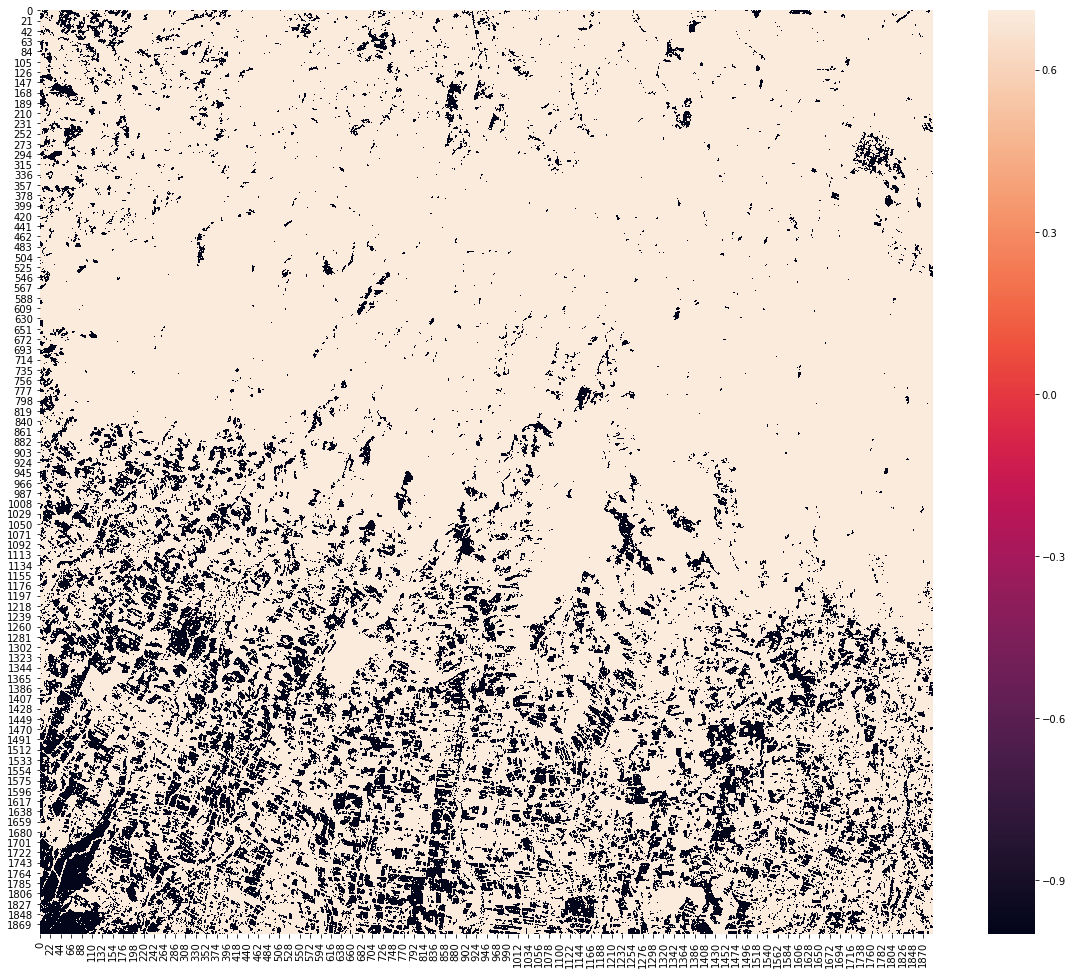

In [40]:
plt.figure(figsize=(20, 17))
thresh_p = 0.3
#stacked = predictions
stacked[np.where(stacked > thresh_p)] = 0.71
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 1.
sns.heatmap(stacked)
#sns.heatmap(stacked[568:-41, 52:104]) # senegal-a is [568:-41, 52:104]

# 3.0 Write GeoTiff

In [56]:
landscapes = {
    'ethiopia-tigray': (13.540810, 38.177220),
    'kenya-makueni-2': (-1.817109, 37.44563),
    'ghana': (9.259359, -0.83375),
    'niger-koure': (13.18158, 2.478),
    'cameroon-farnorth': (10.596, 14.2722),
    'mexico-campeche': (18.232495, -92.1234215),
    'malawi-rumphi': (-11.044, 33.818),
    'ghana-sisala-east': (10.385, -1.765),
    'ghana-west-mamprusi': (10.390084, -0.846330),
    'ghana-kwahu': (6.518909, -0.826008),
    'senegal-16b': (15.82585, -15.34166),
    'india-kochi': (9.909, 76.254),
    'india-sidhi': (24.0705, 81.607),
    'brazil-esperito-santo': (-20.147, -40.837),
    'brazil-paraiba': (-22.559943, -44.186629),
    'brazil-goias': (-14.905595, -48.907399),
    'colombia-talima': (4.179529, -74.889171),
    'drc-kafubu': (-11.749636, 27.586622),
    'thailand-khon-kaen': (15.709725, 102.546518),
    'indonesia-west-java': (-6.721101, 108.280949),
    'madagascar': (-18.960152, 47.469587),
    'tanzania': (-6.272258, 36.679824),
    'chile': (-36.431237, -71.872030),
    'indonesia-jakarta': (-6.352580, 106.677072),
    'caf-baboua': (5.765917, 14.791618),   
    'honduras': (14.096664, -88.720304),
    'nicaragua': (12.398014, -86.963042),
    'china': (26.673679, 107.464231),
    'australia-west': (-32.666762, 117.411197),
    'mexico-sonora': (29.244288, -111.243230),
    'south-africa': (-30.981698, 28.727301),
    'maldonado-uraguay': (-34.629250, -55.004331),
    'dominican-rep-la-salvia': (18.872589, -70.462961),
    'guatemala-coban': (15.3, -90.8),
    'senegal-tucker-a': (15.350595, -15.459789),
    'elsalvador-imposible': (13.727334, -90.015579),
    'peru-shatoja-district': (-6.566366, -76.759752),
    'angola-galanga': (-12.104782, 15.151222),
    'morocco-chefchaouen': (34.942560, -4.772589),
    'georgia-imereti': (42.223069, 42.603353),
    'drc-mai-ndombe' : (-3.696119, 20.362077),
    'malawi-salima': (-13.6, 34.32),
    'brazil-para': (-2.064534, -56.578095),
    'brazil-para-2': (-7.351687, -48.457507),
    'pakistan-mardan': (34.355452, 71.945095),
    'botswana-kweneng': (-24.360968, 25.176526),
    'nicaragua-bonanza': (13.933745, -84.690842),
    'ghana-cocoa': (7.398111, -1.269223),
    'ghana-brong-ahafo': (7.70258, -0.70911),
    'mexico-change-det': (21.212083, -88.993677),
    'costa-rica-change-det': (8.47520, -82.94909),
    'mexico-yucatan': (21.062115, -88.998729),
    'honduras-colon': (15.617889, -85.447611),
    'mexico-campeche-change': (18.151747, -92.152278),
    'guatemala-gain': (16.464444, -89.479170),
    'guatemala-gain-2': (15.196480, -89.118290),
    'uganda-agroforestry': (2.353267, 32.681427),
    'brazil-enrichment': (-26.116734, -51.415170),
    'uganda-agroforestry-2': (2.333234, 32.657905),
    'rwanda-agroforestry': (-1.40, 30.459),
    'brazil-buffer': (-20.117451, -50.364266),
    'brazil-restoration': (-22.228324, -50.963621),
    'brazil-native-p': (-21.785180, -47.280192),
    'brazil-patch-p': (-23.379173, -47.272593),
    'brazil-lake': (-23.675035, -46.315154),
    'brazil-enrichment-2': (-23.032334, -46.175910),
    'brazil-streambank': (-24.764847, -48.193073),
    'brazil-planting-2': (-23.301148, -45.649483),
    'brazil-gulley': (-22.054421, -52.055029),
    'brazil-planting': (-23.583940, -47.574845),
    'brazil-planting-3': (-23.388818, -47.286080),
    'brazil-tropics': (-24.775491, -48.072984),
    'brazil-small': (-22.040039, -47.826367),
    'brazil-gulley-east': (-21.971591, -51.829941)
}

landscape = 'brazil-buffer'
coords = landscapes[landscape]
coords = (coords[1], coords[0])
point = bounding_box(coords, (max_x*1260)-0, ((max_y)*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]
print(max_y)

5


In [57]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

print("Writing" + '../../ce-hosting/includes/{}.tif'.format(landscape))
new_dataset = rasterio.open('../../ce-hosting/includes/{}-2019-new.tif'.format(landscape), 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

Writing../../ce-hosting/includes/brazil-buffer.tif


# 3.1 Cloud optimized Geotiff

In [26]:
!gdal_translate ../../ce-hosting/includes/drc-kafubu.tif ../tile_data/cog/drc-kafubu.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/drc-kafubu.tif 2 4 8 16
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

Input file size is 630, 630
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# 3.2 Half-hectare tree density Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.8)
summed += 0.1

In [ ]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()